<a href="https://colab.research.google.com/github/pachterlab/GP_ExtNois_Aug2020/blob/master/fig_generator_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import nbinom
%config InlineBackend.figure_format = 'retina'

Collect code from Github. Import simulation functions.

In [2]:
!wget -O ext_noise_gill.py https://raw.githubusercontent.com/pachterlab/GP_ExtNois_Aug2020/master/ext_noise_gill.py?token=AKPPGCXK25TMNX4LHCVDDEK7LRZGC

--2020-09-05 23:36:13--  https://raw.githubusercontent.com/pachterlab/GP_ExtNois_Aug2020/master/ext_noise_gill.py?token=AKPPGCXK25TMNX4LHCVDDEK7LRZGC
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6586 (6.4K) [text/plain]
Saving to: ‘ext_noise_gill.py’

ext_noise_gill.py   100%[===================>]   6.43K  --.-KB/s    in 0s      

2020-09-05 23:36:13 (56.3 MB/s) - ‘ext_noise_gill.py’ saved [6586/6586]



In [3]:
from ext_noise_gill import *

In [4]:
#aesthetics
LINECOL = [0.85,0.33,0.10]
HISTCOL = [0.7]*3
LINEWIDTH = 2
ALFA = 0.05
MARKERSIZE=1
np.random.seed(2300)

Define parameters for burst model. Run simulation.

In [5]:
beta = 0.5
kinit = 0.9
gamma = 0.4
bs = 12
nCells = 10000
S_burst = np.array([[bs,0], [-1,1], [0,-1]])
nT = 3
kpar = [kinit,beta,gamma]
Tmax = 10/min(kpar)
tvec = np.linspace(0,Tmax,nT)
t_matrix = np.matlib.repmat(tvec,nCells,1)

In [6]:
X1 = gill_burst(kpar,t_matrix,S_burst,nCells)

Define equivalent parameters for extrinsic noise model. Run simulation.

In [7]:
S_ext = np.array([[1,0], [-1,1], [0,-1]])
gamma_a = kinit/beta
gamma_eta = 1/(beta*bs)
prob_nas = gamma_eta*beta/(gamma_eta*beta+1)
prob_mat = gamma_eta*gamma/(gamma_eta*gamma+1)
gamma_params = [gamma_a,gamma_eta]

In [8]:
X2 = gill_gamma_K(kpar,t_matrix,S_ext,nCells,gamma_params)

Visualize results. Note that lighter regions correspond to higher probability masses.

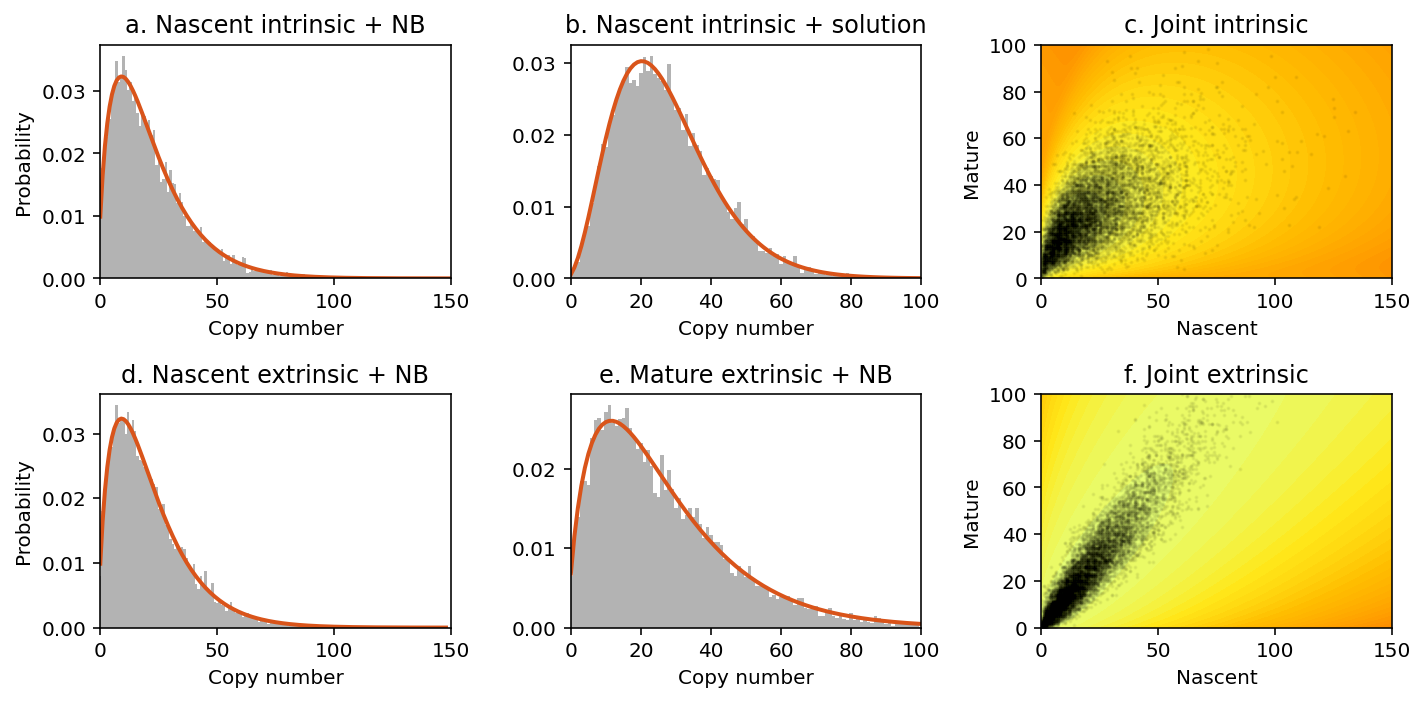

In [9]:
sz=(2,3)
fig1,ax1=plt.subplots(nrows=sz[0],ncols=sz[1],figsize=(10,5))

xlim_U = [0,150]
xlim_S = [0,100]

sU = np.random.normal(0,0.1,nCells)
sS = np.random.normal(0,0.1,nCells)

### intrinsic noise
U=X1[:,-1,0]
S=X1[:,-1,1]

ax1[0,0].hist(U,density=True,bins=np.arange(max(U)+2)-0.5,color=HISTCOL)
x_ = np.arange(max(U)+1)
ax1[0,0].plot(x_,nbinom.pmf(x_,kinit/beta,1/(1+bs)),color=LINECOL,linewidth=LINEWIDTH)
ax1[0,0].set_xlim(xlim_U)
ax1[0,0].set_xlabel('Copy number')
ax1[0,0].set_ylabel('Probability')
ax1[0,0].set_title('a. Nascent intrinsic + NB')

ax1[0,1].hist(S,density=True,bins=np.arange(max(U)+2)-0.5,color=HISTCOL)
x_ = np.arange(max(S)+1)
y_ = cme_integrator([kinit,bs,gamma,beta],max(U)+1,max(S)+1,np.inf,'mature').T
ax1[0,1].plot(x_,y_,color=LINECOL,linewidth=LINEWIDTH)
ax1[0,1].set_xlim(xlim_S)
ax1[0,1].set_xlabel('Copy number')
ax1[0,1].set_title('b. Nascent intrinsic + solution')

joint_max = [max(max(U)+10,xlim_U[1]+1),max(max(S)+10,xlim_S[1]+1)]
X_,Y_ = np.meshgrid(np.arange(joint_max[0]),np.arange(joint_max[1]))
Z_ = cme_integrator([kinit,bs,gamma,beta],joint_max[0],joint_max[1],np.inf,'none')
ax1[0,2].contourf(X_.T,Y_.T,np.log10(Z_),30,cmap='Wistia_r')
ax1[0,2].scatter(U+sU,S+sU,MARKERSIZE,'k',alpha=ALFA)
ax1[0,2].set_xlim(xlim_U)
ax1[0,2].set_ylim(xlim_S)
ax1[0,2].set_xlabel('Nascent')
ax1[0,2].set_ylabel('Mature')
ax1[0,2].set_title('c. Joint intrinsic')

### extrinsic noise
U=X2[:,-1,0]
S=X2[:,-1,1]

ax1[1,0].hist(U,density=True,bins=np.arange(max(U)+2)-0.5,color=HISTCOL)
x_ = np.arange(max(U)+1)
ax1[1,0].plot(x_,nbinom.pmf(x_,gamma_a,prob_nas),color=LINECOL,linewidth=LINEWIDTH)
ax1[1,0].set_xlim(xlim_U)
ax1[1,0].set_xlabel('Copy number')
ax1[1,0].set_ylabel('Probability')
ax1[1,0].set_title('d. Nascent extrinsic + NB')

ax1[1,1].hist(S,density=True,bins=np.arange(max(U)+2)-0.5,color=HISTCOL)
x_ = np.arange(max(S)+1)
ax1[1,1].plot(x_,nbinom.pmf(x_,gamma_a,prob_mat),color=LINECOL,linewidth=LINEWIDTH)
ax1[1,1].set_xlim(xlim_S)
ax1[1,1].set_xlabel('Copy number')
ax1[1,1].set_title('e. Mature extrinsic + NB')

joint_max = [max(U)+10,max(S)+10]
X_,Y_ = np.meshgrid(np.arange(joint_max[0]),np.arange(joint_max[1]))
Z_ = MVNB(gamma_a,gamma_eta,beta,gamma,joint_max[0],joint_max[1])
ax1[1,2].contourf(X_,Y_,np.log10(Z_),30,cmap='Wistia_r')
ax1[1,2].scatter(U+sU,S+sS,MARKERSIZE,'k',alpha=ALFA)
ax1[1,2].set_xlim(xlim_U)
ax1[1,2].set_ylim(xlim_S)
ax1[1,2].set_xlabel('Nascent')
ax1[1,2].set_ylabel('Mature')
ax1[1,2].set_title('f. Joint extrinsic')

fig1.tight_layout()
plt.savefig('fig1.png',dpi=600)